In [1]:
from main import PennFudanDataset, get_instance_segmentation_model, get_transform, map_iou
import pandas as pd
import torch
import utils
from itertools import chain
from engine import train_one_epoch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# use our dataset and defined transformations
dataset = PennFudanDataset('/media/jaidevd/motherbox/archive/pennfudan/PennFudanPed', None, get_transform(train=True))
dataset_test = PennFudanDataset('/media/jaidevd/motherbox/archive/pennfudan/PennFudanPed', None, get_transform(train=False))

# split the dataset in train and test set
# torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:85])
dataset_test = torch.utils.data.Subset(dataset_test, indices[85:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=5, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01,
                            momentum=0.9, weight_decay=0.005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/home/jaidevd/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/jaidevd/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: [0]  [ 0/17]  eta: 0:00:28  lr: 0.000634  loss: 4.6207 (4.6207)  loss_classifier: 0.8299 (0.8299)  loss_box_reg: 0.3087 (0.3087)  loss_mask: 3.4603 (3.4603)  loss_objectness: 0.0174 (0.0174)  loss_rpn_box_reg: 0.0044 (0.0044)  time: 1.6895  data: 0.2248  max mem: 5981
Epoch: [0]  [16/17]  eta: 0:00:00  lr: 0.010000  loss: 0.8289 (1.3940)  loss_classifier: 0.2120 (0.2837)  loss_box_reg: 0.2307 (0.2408)  loss_mask: 0.2985 (0.8523)  loss_objectness: 0.0071 (0.0106)  loss_rpn_box_reg: 0.0059 (0.0065)  time: 0.9665  data: 0.0206  max mem: 7713
Epoch: [0] Total time: 0:00:16 (0.9676 s / it)
Epoch: [1]  [ 0/17]  eta: 0:00:18  lr: 0.010000  loss: 0.5837 (0.5837)  loss_classifier: 0.0804 (0.0804)  loss_box_reg: 0.1920 (0.1920)  loss_mask: 0.2995 (0.2995)  loss_objectness: 0.0021 (0.0021)  loss_rpn_box_reg: 0.0097 (0.0097)  time: 1.1112  data: 0.2063  max mem: 7713
Epoch: [1]  [16/17]  eta: 0:00:00  lr: 0.010000  loss: 0.4358 (0.4294)  loss_classifier: 0.0509 (0.0547)  loss_box_reg: 0.164

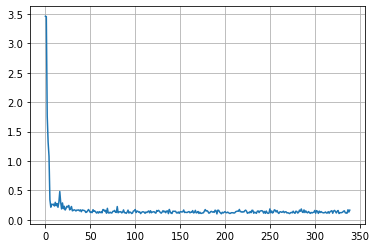

In [4]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 20
LOSSES = []

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    _, losses = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=17)
    # update the learning rate
    lr_scheduler.step()
    LOSSES.append(losses)
    # evaluate on the test dataset
    # evaluate(model, data_loader_test, device=device)

    

LOSSES = chain(*[[k['loss_mask'] for k in ep] for ep in LOSSES])
plt.plot([k.to('cpu').detach().numpy().item() for k in LOSSES])
plt.grid()
plt.show()

In [5]:
metrics = {}
model.eval()

for ((image,), (ann,)) in data_loader_test:
    imid = ann['image_id'].item()
    y_pred = model([image.to('cuda')])[0]
    
    
    yt = ann['masks'].to('cpu').numpy()
    yp = y_pred['masks'].to('cpu').detach().numpy()
    yp = np.squeeze(yp, axis=1)
    metrics[imid] = map_iou(yt.astype(bool), yp > 0.5), yt.astype(bool), yp > 0.5

ious = pd.Series({k: v[0] for k, v in metrics.items()})

14     0.114286
104    0.166667
82     0.194432
33     0.200000
16     0.200000
dtype: float64

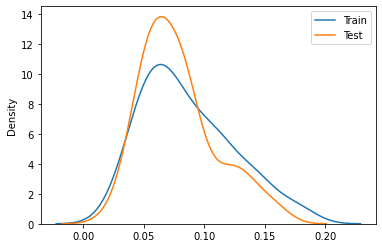

In [8]:
train_mean = {}
test_mean = {}


def mean_area(ann):
    imid1 = ann['image_id'].item()
    mask1 = ann['masks'].numpy()
    h1, w1 = mask1.shape[1:]
    return {imid1: np.mean(mask1.sum(1).sum(1) / (h1 * w1))}

for _, anns in data_loader:
    for ann in anns:
        train_mean.update(mean_area(ann))

for _, (ann,) in data_loader_test:
    mask = ann['masks'].numpy()
    h, w = mask.shape[1:]
    test_mean[ann['image_id'].item()] = np.mean(mask.sum(1).sum(1) / (h * w))


    
fig, ax = plt.subplots(nrows=1, ncols=2)
train_mean, test_mean = map(pd.Series, (train_mean, test_mean))
sns.kdeplot(train_mean.values, label='Train', ax=ax[0])
sns.kdeplot(test_mean.values, label='Test', ax=ax[0])
ax[0].legend()

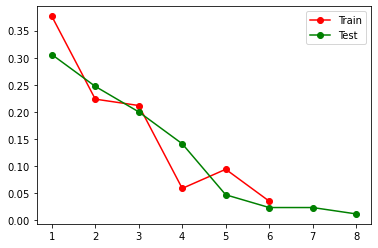

In [9]:
train_n = {}
test_n = {}

def n_pedestrians(ann):
    return {ann['image_id'].item(): ann['masks'].shape[0]}


for _, anns in data_loader:
    for ann in anns:
        train_n.update(n_pedestrians(ann))

for _, (ann,) in data_loader_test:
    test_n[ann['image_id'].item()] = ann['masks'].shape[0]
    
train_n, test_n = map(pd.Series, (train_n, test_n))

train_vc = train_n.value_counts(normalize=True).sort_index()
test_vc = test_n.value_counts(normalize=True).sort_index()

ax[1].plot(train_vc.index, train_vc.values, 'ro-', label='Train')
ax[1].plot(test_vc.index, test_vc.values, 'go-', label='Test')
ax[1].legend()

plt.show()

In [ ]:
print(ious.mean())